In [2]:
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms

raw_dataset = SEEDDataset(
    root_path='./SEED/SEED_EEG/Preprocessed_EEG',
    io_path = 'E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,  # Disable transforms
    label_transform=None,
    num_worker=4
)

raw_sample = raw_dataset[0]
print(f"Raw EEG data shape: {raw_sample[0].shape}")  # Should be [62, ...] for SEED

[2024-12-05 02:45:11] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Raw EEG data shape: (62, 200)


In [3]:
print(raw_dataset[0])

(array([[-19.28210258,  -9.29832458, -25.77900887, ..., -15.55681229,
        -17.49396324, -19.90795135],
       [ 11.92092896,  20.53380013,  11.41428947, ...,   3.21865082,
         -1.16229057,  13.76867294],
       [  0.56624413,  18.80526543, -11.08646393, ..., -26.4942646 ,
        -23.66304398,   8.31484795],
       ...,
       [  3.4570694 ,  10.72883606,  -6.7949295 , ...,  12.54677773,
         10.46061516,  14.42432404],
       [  5.24520874,  11.77191734,  -3.66568565, ...,  15.07997513,
         11.41428947,  20.02716064],
       [  9.08970833,   6.34789467,   1.16229057, ...,  10.37120819,
         12.54677773,  17.94099808]]), {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'})


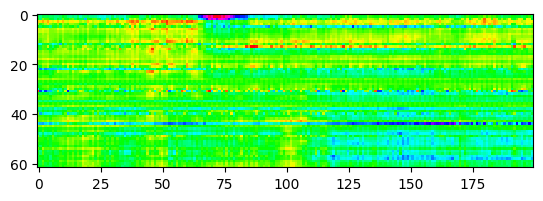

In [4]:
import torch
from torcheeg.utils import plot_2d_tensor

img = plot_2d_tensor(torch.tensor(raw_dataset[0][0]))

In [5]:
import numpy as np
from scipy.signal import butter, lfilter

# Define a bandpass filter (4-47 Hz for SEED dataset)
def bandpass_filter(data, lowcut=4, highcut=47, fs=200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=-1)

# Apply bandpass filtering to the raw EEG data
preprocessed_data = bandpass_filter(raw_sample[0])

print(f"Preprocessed EEG data shape: {preprocessed_data.shape}")


Preprocessed EEG data shape: (62, 200)


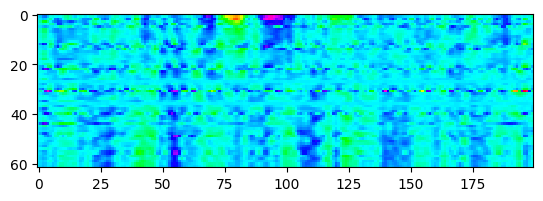

In [6]:
img = plot_2d_tensor(torch.tensor(preprocessed_data))

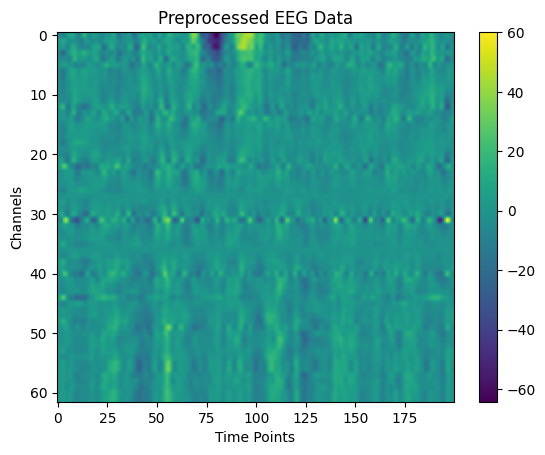

In [7]:
import matplotlib.pyplot as plt

# Visualize the preprocessed EEG data
plt.imshow(preprocessed_data, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Preprocessed EEG Data')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.show()


In [8]:
# Perform stratified normalization (z-score)
def stratified_normalization(data):
    normalized_data = (data - np.mean(data, axis=-1, keepdims=True)) / np.std(data, axis=-1, keepdims=True)
    return normalized_data

# Normalize the preprocessed EEG data
normalized_data = stratified_normalization(preprocessed_data)

print(f"Normalized EEG data shape: {normalized_data.shape}")


Normalized EEG data shape: (62, 200)


In [9]:
import torch

def data_sampler(dataset , time_length=30 , step_size=15):
    samples = []
    for sample in dataset:
        data, metadata = sample
        subject_id = metadata['subject_id']
        trial_length = data.shape[1]
        
        for start in range(0, trial_length - time_length + 1, step_size):
            segment = data[: , start:start+time_length]
            samples.append((segment , subject_id))
    return samples

# Define the time length and step size for segmenting the EEG data
time_length = 30  # 30 time points (150 ms) per segment
step_size = 15  # 15 time points (75 ms) step size between segments

segments = data_sampler(raw_dataset, time_length=time_length, step_size=step_size)
print(f"Number of segments: {len(segments)}")
print(f"Segment shape: {segments[0][0].shape} , Subject ID: {segments[0][1]}")


Number of segments: 1832760
Segment shape: (62, 30) , Subject ID: 10


In [10]:
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16 , temporal_filter_size=48 , temporal_filters=16):
        super(BaseEncoder, self).__init__()
        
        # Spatial convolutional layer
        self.spatial_conv = nn.Conv1d(in_channels=num_channels,out_channels=spatial_filters,kernel_size=1)
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters,out_channels=temporal_filters,kernel_size=temporal_filter_size,padding=temporal_filter_size//2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        # Apply temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    
#Initialize the encoder
base_encoder = BaseEncoder(num_channels=62, spatial_filters=16, temporal_filter_size=48, temporal_filters=16)

#Test on the sample segment
sample_segment = torch.tensor(segments[0][0], dtype=torch.float32).unsqueeze(0)
encoded_output = base_encoder(sample_segment)

print(f"Sample segment shape: {sample_segment.shape}")
print(f"Encoded output shape: {encoded_output.shape}")
        

Sample segment shape: torch.Size([1, 62, 30])
Encoded output shape: torch.Size([1, 16, 31])


In [11]:
# Define the Projector
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, pooling_kernel=24, temporal_filter_size=4 , c=2):
        super(Projector, self).__init__()
        #Average Pooling
        
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel , stride=pooling_kernel)
        #spatial convolution        
        self.spatial_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=spatial_filters*c,kernel_size=1)
        #temporal convolution
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters*c,out_channels=(spatial_filters*c)*c, kernel_size=temporal_filter_size, padding=temporal_filter_size//2)
        #Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #Applying avg pooling
        x = self.avg_pool(x)
        #Applying spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        #Applying temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    


# Initialize the projector
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4,c=2)

# Test on the encoded output
projected_output = projector(encoded_output)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Projected output shape: {projected_output.shape}")

Encoded output shape: torch.Size([1, 16, 31])
Projected output shape: torch.Size([1, 64, 2])


In [12]:
import torch
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, z_i, z_j):
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Compute similarity matrix
        similarities = torch.matmul(z_i, z_j.T) / self.temperature
        
        # Labels for contrastive loss
        batch_size = z_i.size(0)
        labels = torch.arange(batch_size).long().to(z_i.device)
        
        # Cross-entropy loss
        loss = F.cross_entropy(similarities, labels)
        return loss

# Initialize the contrastive loss
contrastive_loss = ContrastiveLoss(temperature=0.5)

#Generate mock positive pairs( outputs from the projector for paired samples)
z_i = projected_output.view(projected_output.size(0), -1)
z_j = projected_output.view(projected_output.size(0), -1)

#Compute the contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss: {loss.item()}")

        

Contrastive loss: 0.0


In [13]:
# Generate mock embeddings for testing
batch_size = 4  # Example batch size
feature_dim = 64  # Match the projector's output size

# Create positive pairs (slightly perturbed to simulate similarity)
z_i = torch.rand(batch_size, feature_dim)
z_j = z_i + torch.normal(mean=0, std=0.01, size=z_i.size())  # Add small noise to simulate similarity

# Normalize embeddings
z_i = F.normalize(z_i, dim=1)
z_j = F.normalize(z_j, dim=1)

# Compute contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss with mock positive pairs: {loss.item()}")


Contrastive loss with mock positive pairs: 1.0283324718475342


In [14]:
import numpy as np

#function to compute (DE)
def compute_de_features(eeg_data):
    variance = np.var(eeg_data, axis=-1)
    de_features = 0.5 * np.log2(2* np.pi * np.e * variance)
    return de_features

# Compute DE features for the sample segment
aligned_representation = encoded_output.detach().numpy().squeeze()
de_features = compute_de_features(aligned_representation)

print(f"DE features shape: {de_features.shape}")
print(f"DE features: {de_features}")

DE features shape: (16,)
DE features: [2.1389687  2.0037007  2.242185   2.0763323  2.6951025  2.8398924
 2.544395   3.3261242  2.511706   3.0091367  0.97421956 0.9878154
 2.1360397  0.28098398 0.1658992  1.5296819 ]


In [15]:
import torch.nn as nn
import torch.optim as optim

class MLPCLassifier(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=30, output_dim=3):
        super(MLPCLassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
# Initialize the classifier
mlp_classifier = MLPCLassifier(input_dim=16, hidden_dim=30, output_dim=3)

#Test the classifier
de_features_tensor = torch.tensor(de_features, dtype=torch.float32).unsqueeze(0)
output = mlp_classifier(de_features_tensor)

print(f"DE features shape: {de_features_tensor.shape}")
print(f"Classifier output shape: {output.shape}")
print(f"Predictied emotion probabilities: {output}")

DE features shape: torch.Size([1, 16])
Classifier output shape: torch.Size([1, 3])
Predictied emotion probabilities: tensor([[0.4143, 0.3095, 0.2761]], grad_fn=<SoftmaxBackward0>)


In [16]:
import torch.utils.data as data

# Mock Dataset for Training (Replace with actual DE feature dataset)
class DEFeatureDataset(data.Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples
        self.features = torch.randn(num_samples, 16)  # Random DE features
        self.labels = torch.randint(0, 3, (num_samples,))  # Random labels (3 emotion categories)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Initialize Dataset and DataLoader
dataset = DEFeatureDataset(num_samples=100)
data_loader = data.DataLoader(dataset, batch_size=16, shuffle=True)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.001)

# Training Loop
for epoch in range(5):  # Train for 5 epochs
    total_loss = 0
    for batch_features, batch_labels in data_loader:
        optimizer.zero_grad()
        predictions = mlp_classifier(batch_features)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}")


Epoch 1, Loss: 1.096686635698591
Epoch 2, Loss: 1.0909110477992467
Epoch 3, Loss: 1.0896571704319544
Epoch 4, Loss: 1.09063948903765
Epoch 5, Loss: 1.0948098387037004


In [17]:
# Evaluation Dataset (Mock Testing Data)
test_dataset = DEFeatureDataset(num_samples=20)  # Smaller dataset for testing
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluation Loop
mlp_classifier.eval()  # Set the classifier to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        predictions = mlp_classifier(batch_features)
        predicted_labels = torch.argmax(predictions, dim=1)
        correct += (predicted_labels == batch_labels).sum().item()
        total += batch_labels.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 30.00%


APPLICATION TO WHOLE DATA

In [18]:
# Function to process the entire dataset
def process_dataset(dataset):
    processed_segments = []
    for sample in dataset:
        eeg_data, metadata = sample

        # Bandpass filter
        filtered_data = bandpass_filter(eeg_data)

        # Append metadata for reference
        processed_segments.append((filtered_data, metadata))

    return processed_segments

# Process the raw dataset
processed_data = process_dataset(raw_dataset)
print(f"Processed {len(processed_data)} EEG samples.")
print(f"First processed sample shape: {processed_data[0][0].shape}")

Processed 152730 EEG samples.
First processed sample shape: (62, 200)


Checking for Artifacts

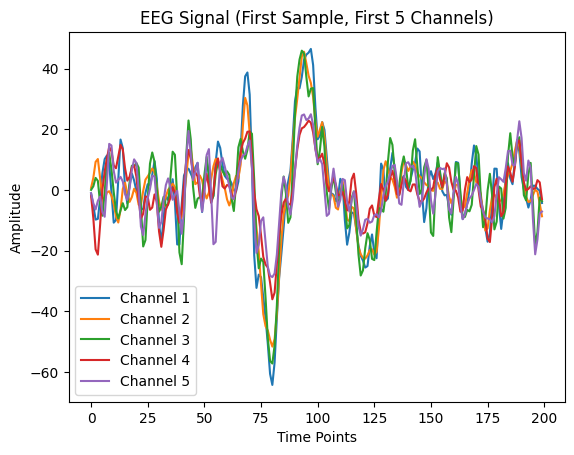

In [19]:
import matplotlib.pyplot as plt

# Visualize EEG signal for the first sample and first 5 channels
eeg_data, _ = processed_data[0]  # Replace with normalized_data if already normalized
for channel in range(5):  # Visualize first 5 channels
    plt.plot(eeg_data[channel, :], label=f'Channel {channel+1}')
plt.title('EEG Signal (First Sample, First 5 Channels)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [20]:
# Compute variance across time points for each channel
eeg_data, _ = processed_data[0]
variance = np.var(eeg_data, axis=1)
print(f'Variance across channels: {variance}')

# Flag channels with unusually high variance
threshold = np.mean(variance) + 3 * np.std(variance)  # 3-sigma rule
artifact_channels = np.where(variance > threshold)[0]
print(f'Channels with artifacts: {artifact_channels}')


Variance across channels: [2.88711124e+02 2.18970653e+02 2.39640774e+02 9.92589084e+01
 1.03980378e+02 6.59008687e+01 5.36339461e+01 3.75502305e+01
 3.17774269e+01 3.08489418e+01 3.45634075e+01 4.07416981e+01
 7.47830643e+01 5.56228761e+01 7.56380017e+01 3.47239044e+01
 1.75527078e+01 1.10857114e+01 1.47321980e+01 1.08047042e+01
 2.32862554e+01 5.71502909e+01 8.13472500e+01 5.19968752e+01
 2.90521157e+01 1.67339063e+01 9.67938366e+00 1.79470810e-01
 6.10604941e+00 1.75851697e+01 6.74993834e+01 3.16524470e+02
 3.82455975e+01 2.45000311e+01 1.68617385e+01 1.09527791e+01
 1.60944414e-01 8.10107852e+00 2.59409116e+01 3.52847480e+01
 9.64959093e+01 4.23698233e+01 3.60389108e+01 2.61315133e+01
 6.39326734e+01 1.30697148e+01 1.84383763e+01 3.47911670e+01
 5.46073495e+01 7.45168250e+01 4.60223185e+01 4.80595469e+01
 3.57531413e+01 2.93699280e+01 4.23142032e+01 6.74216867e+01
 7.09997871e+01 4.97636229e+01 4.03753037e+01 4.10292845e+01
 4.82002698e+01 5.01593071e+01]
Channels with artifacts: [ 

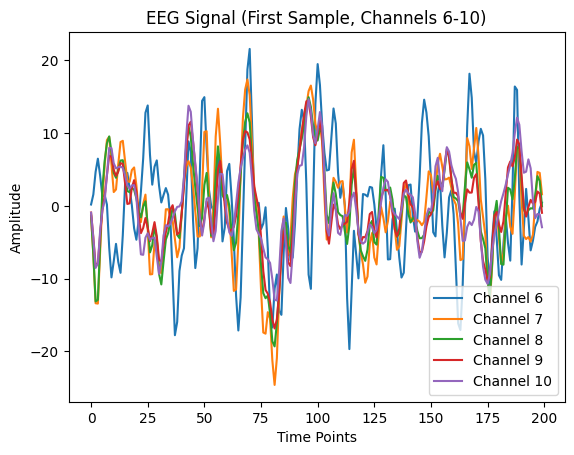

In [21]:
# Visualize next 5 channels of the first sample
for channel in range(5, 10):  # Channels 6 to 10
    plt.plot(eeg_data[channel, :], label=f'Channel {channel+1}')
plt.title('EEG Signal (First Sample, Channels 6-10)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [22]:
# Compute variance for the first sample
variance = np.var(eeg_data, axis=1)
print(f'Variance across channels: {variance}')


Variance across channels: [2.88711124e+02 2.18970653e+02 2.39640774e+02 9.92589084e+01
 1.03980378e+02 6.59008687e+01 5.36339461e+01 3.75502305e+01
 3.17774269e+01 3.08489418e+01 3.45634075e+01 4.07416981e+01
 7.47830643e+01 5.56228761e+01 7.56380017e+01 3.47239044e+01
 1.75527078e+01 1.10857114e+01 1.47321980e+01 1.08047042e+01
 2.32862554e+01 5.71502909e+01 8.13472500e+01 5.19968752e+01
 2.90521157e+01 1.67339063e+01 9.67938366e+00 1.79470810e-01
 6.10604941e+00 1.75851697e+01 6.74993834e+01 3.16524470e+02
 3.82455975e+01 2.45000311e+01 1.68617385e+01 1.09527791e+01
 1.60944414e-01 8.10107852e+00 2.59409116e+01 3.52847480e+01
 9.64959093e+01 4.23698233e+01 3.60389108e+01 2.61315133e+01
 6.39326734e+01 1.30697148e+01 1.84383763e+01 3.47911670e+01
 5.46073495e+01 7.45168250e+01 4.60223185e+01 4.80595469e+01
 3.57531413e+01 2.93699280e+01 4.23142032e+01 6.74216867e+01
 7.09997871e+01 4.97636229e+01 4.03753037e+01 4.10292845e+01
 4.82002698e+01 5.01593071e+01]


In [23]:
# Remove artifact channels
artifact_free_data = np.delete(eeg_data, [0, 2, 31], axis=0)  # Remove channels 0, 2, and 31
print(f"Shape after removing artifact channels: {artifact_free_data.shape}")


Shape after removing artifact channels: (59, 200)


In [24]:
# Recompute variance
updated_variance = np.var(artifact_free_data, axis=1)
print(f"Updated variance across channels: {updated_variance}")


Updated variance across channels: [2.18970653e+02 9.92589084e+01 1.03980378e+02 6.59008687e+01
 5.36339461e+01 3.75502305e+01 3.17774269e+01 3.08489418e+01
 3.45634075e+01 4.07416981e+01 7.47830643e+01 5.56228761e+01
 7.56380017e+01 3.47239044e+01 1.75527078e+01 1.10857114e+01
 1.47321980e+01 1.08047042e+01 2.32862554e+01 5.71502909e+01
 8.13472500e+01 5.19968752e+01 2.90521157e+01 1.67339063e+01
 9.67938366e+00 1.79470810e-01 6.10604941e+00 1.75851697e+01
 6.74993834e+01 3.82455975e+01 2.45000311e+01 1.68617385e+01
 1.09527791e+01 1.60944414e-01 8.10107852e+00 2.59409116e+01
 3.52847480e+01 9.64959093e+01 4.23698233e+01 3.60389108e+01
 2.61315133e+01 6.39326734e+01 1.30697148e+01 1.84383763e+01
 3.47911670e+01 5.46073495e+01 7.45168250e+01 4.60223185e+01
 4.80595469e+01 3.57531413e+01 2.93699280e+01 4.23142032e+01
 6.74216867e+01 7.09997871e+01 4.97636229e+01 4.03753037e+01
 4.10292845e+01 4.82002698e+01 5.01593071e+01]


Moving towards normalization
The next step is to normalize the data. Normalization is a process of scaling the data to a

In [25]:
import numpy as np

def incremental_normalization(process_dataset):
    normalized_segments = []
    subject_data_stats = {}
    
    #First pass : computing mean and variance incrementally for each subject
    for eeg_data, metadata in process_dataset:
        subject_id = metadata['subject_id']
        if subject_id not in subject_data_stats:
            subject_data_stats[subject_id] = {'sum':0, 'sum_sq':0, "count":0}
            
        stats = subject_data_stats[subject_id]
        stats['sum'] += np.sum(eeg_data, axis=-1, keepdims=True)
        stats['sum_sq'] += np.sum(eeg_data**2, axis=-1, keepdims=True)
        stats['count'] += eeg_data.shape[1]
        
    #Compute mean and standard deviation for each subject
    for subject_id, stats in subject_data_stats.items():
        stats['mean'] = stats['sum'] / stats['count']
        stats['std'] = np.sqrt(stats['sum_sq'] / stats['count'] - stats['mean']**2)
        
        
    #Second pass : Normalizing each segment using computed stats
    for eeg_data, metadata in process_dataset:
        subject_id = metadata['subject_id']
        stats = subject_data_stats[subject_id]
        mean = stats['mean']
        std = stats['std']
        normalized_data = (eeg_data - mean) / std
        normalized_segments.append((normalized_data, metadata))
        
    return normalized_segments

# Normalize the processed dataset
normalized_data = incremental_normalization(processed_data)

#output the normalized data
print(f"Normalized {len(normalized_data)} EEG samples.")
print(f"First normalized sample shape: {normalized_data[0][0].shape}")
        
        

Normalized 152730 EEG samples.
First normalized sample shape: (62, 200)


Data Sampling

In [26]:
# Function to sample data into fixed length segments
def sample_data(normalized_data, time_length=30, step_size=15):
    sampled_segments = []
    
    for eeg_data, metadata in normalized_data:
        trial_length = eeg_data.shape[1]
        
        for start in range(0 , trial_length - time_length + 1, step_size):
            segment = eeg_data[:, start:start+time_length]
            new_metadata = metadata.copy()
            new_metadata['segment_start'] = start
            new_metadata['segment_end'] = start + time_length
            sampled_segments.append((segment, new_metadata))
    
    return sampled_segments

# Sample the normalized data
time_length = 30
step_size = 15
sampled_data = sample_data(normalized_data, time_length=time_length, step_size=step_size)
            
# Output the sampled data
print(f"Generated {len(sampled_data)} EEG segments.")
print(f"First sampled segment shape: {sampled_data[0][0].shape}")

Generated 1832760 EEG segments.
First sampled segment shape: (62, 30)


In [28]:
# Function to compute DE features for each segment
def compute_de_features(eeg_segments):
    # eeg_segment shape: [channels, timepoints]
    variance = np.var(eeg_segments, axis=-1)
    de_features = 0.5 * np.log2(2 * np.pi * np.e * variance)
    return de_features

# Extract DE features for the sampled data
de_features_data = []
for segment, metadata in sampled_data:
    de_features = compute_de_features(segment)
    de_features_data.append((de_features, metadata))
    
# Output the DE features data
print(f"Computed DE features for {len(de_features_data)} EEG segments.")
print(f"First DE features shape: {de_features_data[0][0].shape}")

Computed DE features for 1832760 EEG segments.
First DE features shape: (62,)


In [39]:
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, input_channels=62, temporal_filter_length=48, spatial_filters=16, temporal_filters=16):
        super(BaseEncoder, self).__init__()
        # Spatial Convolution
        self.spatial_conv = nn.Conv1d(input_channels, spatial_filters, kernel_size=1)
        # Temporal Convolution
        self.temporal_conv = nn.Conv1d(spatial_filters, temporal_filters, kernel_size=temporal_filter_length, padding=temporal_filter_length // 2)

    def forward(self, x):
        # x shape: [batch_size, input_channels, time_points]
        x = self.spatial_conv(x)
        x = nn.ReLU()(x)
        x = self.temporal_conv(x)
        x = nn.ReLU()(x)
        return x


In [40]:
# Instantiate the base encoder
base_encoder = BaseEncoder(input_channels=62, temporal_filter_length=48, spatial_filters=16, temporal_filters=16)

# Create a mock EEG sample
sample_segment = torch.randn(1, 62, 30)  # Shape: [batch_size, input_channels, time_points]

# Pass the sample through the base encoder
encoded_output = base_encoder(sample_segment)

# Output the shape and sample values
print(f"Encoded output shape: {encoded_output.shape}")
print(f"Sample encoded output (first 5 channels): {encoded_output[0, :, :5]}")


Encoded output shape: torch.Size([1, 16, 31])
Sample encoded output (first 5 channels): tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0800, 0.0882, 0.3560, 0.1443, 0.2183],
        [0.1406, 0.0000, 0.1167, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1554, 0.3540, 0.0197, 0.0000, 0.3507],
        [0.0235, 0.1751, 0.0396, 0.0000, 0.0000],
        [0.0000, 0.0270, 0.1592, 0.0000, 0.0000],
        [0.0154, 0.0000, 0.0000, 0.0037, 0.0357],
        [0.0000, 0.0952, 0.0000, 0.0217, 0.0837],
        [0.0000, 0.0765, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0411, 0.0000, 0.0000],
        [0.1356, 0.2692, 0.0209, 0.0523, 0.0079],
        [0.0330, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0761, 0.2582, 0.0426, 0.0000, 0.0000]], grad_fn=<SliceBackward0>)


In [41]:
# Define the Projector
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, pooling_kernel=24, temporal_filter_size=4 , c=2):
        super(Projector, self).__init__()
        #Average Pooling
        
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel , stride=pooling_kernel)
        #spatial convolution        
        self.spatial_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=spatial_filters*c,kernel_size=1)
        #temporal convolution
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters*c,out_channels=(spatial_filters*c)*c, kernel_size=temporal_filter_size, padding=temporal_filter_size//2)
        #Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #Applying avg pooling
        x = self.avg_pool(x)
        #Applying spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        #Applying temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    


# Initialize the projector
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4,c=2)

# Test on the encoded output
projected_output = projector(encoded_output)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Projected output shape: {projected_output.shape}")

Encoded output shape: torch.Size([1, 16, 31])
Projected output shape: torch.Size([1, 64, 2])


In [42]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        # Normalize embeddings
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        # Compute similarity matrix
        similarities = torch.matmul(z_i, z_j.T) / self.temperature
        
        # Labels for contrastive loss
        batch_size = z_i.size(0)
        labels = torch.arange(batch_size).long().to(z_i.device)
        
        # Compute cross-entropy loss
        loss = nn.CrossEntropyLoss()(similarities, labels)
        return loss


In [43]:
# Create mock embeddings
z_i = torch.randn(4, 64)  # Batch size 4, embedding size 64
z_j = z_i + torch.normal(mean=0, std=0.01, size=z_i.size())  # Slight perturbation for similarity

# Initialize the contrastive loss
contrastive_loss_fn = ContrastiveLoss(temperature=0.5)

# Compute the contrastive loss
loss = contrastive_loss_fn(z_i, z_j)

# Output the loss
print(f"Contrastive loss: {loss.item()}")


Contrastive loss: 0.3112017512321472


In [46]:
# Check unique subject IDs and their sample counts
from collections import Counter

subject_ids = [item[1]['subject_id'] for item in sampled_data]
subject_distribution = Counter(subject_ids)

print(f"Unique Subject IDs: {list(subject_distribution.keys())}")
print(f"Subject Sample Counts: {subject_distribution}")

# Create a mapping for subject IDs
unique_subject_ids = sorted(set(subject_ids))
subject_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_subject_ids)}

# Update subject IDs in metadata
for _, metadata in sampled_data:
    metadata['subject_id'] = subject_id_map[metadata['subject_id']]

# Verify remapping
updated_subject_ids = [item[1]['subject_id'] for item in sampled_data]
updated_subject_distribution = Counter(updated_subject_ids)

print(f"Updated Subject IDs: {list(updated_subject_distribution.keys())}")
print(f"Updated Subject Sample Counts: {updated_subject_distribution}")


Unique Subject IDs: [10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Subject Sample Counts: Counter({10: 122184, 11: 122184, 12: 122184, 13: 122184, 14: 122184, 15: 122184, 1: 122184, 2: 122184, 3: 122184, 4: 122184, 5: 122184, 6: 122184, 7: 122184, 8: 122184, 9: 122184})
Updated Subject IDs: [9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Updated Subject Sample Counts: Counter({9: 122184, 10: 122184, 11: 122184, 12: 122184, 13: 122184, 14: 122184, 0: 122184, 1: 122184, 2: 122184, 3: 122184, 4: 122184, 5: 122184, 6: 122184, 7: 122184, 8: 122184})


In [47]:
def loso_split(dataset, num_subjects):
    """
    Create training and testing splits for Leave-One-Subject-Out (LOSO) Cross-Validation.
    Args:
        dataset: list of tuples (EEG_data, metadata)
        num_subjects: total number of unique subjects in the dataset
    Returns:
        List of splits [(train_data, test_data), ...]
    """
    splits = []
    for test_subject in range(num_subjects):
        # Split dataset into training and testing based on subject ID
        train_data = [item for item in dataset if item[1]['subject_id'] != test_subject]
        test_data = [item for item in dataset if item[1]['subject_id'] == test_subject]
        splits.append((train_data, test_data))
    return splits

# Determine the number of unique subjects
num_subjects = len(set(item[1]['subject_id'] for item in sampled_data))

# Perform LOSO split
loso_splits = loso_split(sampled_data, num_subjects)

# Example: Use the first split
train_data, test_data = loso_splits[0]
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")


Training samples: 1710576, Testing samples: 122184


Inspecting Training and Test Data

In [48]:
# Extract unique subject IDs in training and testing data
train_subjects = set(item[1]['subject_id'] for item in train_data)
test_subjects = set(item[1]['subject_id'] for item in test_data)

print(f"Training Subject IDs: {train_subjects}")
print(f"Testing Subject IDs: {test_subjects}")


Training Subject IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Testing Subject IDs: {0}


In [49]:
# Inspect a random training sample
random_train_sample = train_data[0]
print(f"Random Training Sample Shape: {random_train_sample[0].shape}")
print(f"Random Training Sample Metadata: {random_train_sample[1]}")

# Inspect a random test sample
random_test_sample = test_data[0]
print(f"Random Test Sample Shape: {random_test_sample[0].shape}")
print(f"Random Test Sample Metadata: {random_test_sample[1]}")


Random Training Sample Shape: (62, 30)
Random Training Sample Metadata: {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 0, 'segment_end': 30}
Random Test Sample Shape: (62, 30)
Random Test Sample Metadata: {'start_at': 0, 'end_at': 200, 'clip_id': '1_20131027.mat_0', 'subject_id': 0, 'trial_id': 'djc_eeg1', 'emotion': 1, 'date': 20131027, '_record_id': '_record_18', 'segment_start': 0, 'segment_end': 30}


In [50]:
from collections import Counter

# Check label distribution
train_labels = [item[1]['emotion'] for item in train_data]  # Replace 'emotion' with the actual key for emotion labels
test_labels = [item[1]['emotion'] for item in test_data]

print(f"Training Label Distribution: {Counter(train_labels)}")
print(f"Testing Label Distribution: {Counter(test_labels)}")


Training Label Distribution: Counter({1: 589680, -1: 564480, 0: 556416})
Testing Label Distribution: Counter({1: 42120, -1: 40320, 0: 39744})


Saving the data for later usage

In [1]:
import pickle

# Save training data
with open("./Data/Train/train_data_loso_split.pkl", "wb") as train_file:
    pickle.dump(train_data, train_file)

# Save testing data
with open("./Data/Test/test_data_loso_split.pkl", "wb") as test_file:
    pickle.dump(test_data, test_file)

print("Training and testing data saved successfully!")


NameError: name 'train_data' is not defined